# WESAD Dataset Exploratory Data Analysis

This notebook performs exploratory data analysis on the preprocessed WESAD (Wearable Stress and Affect Detection) dataset. We'll analyze various physiological signals and their relationships with stress states.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style for better visualizations
sns.set_style('whitegrid')
colors = sns.color_palette('husl', n_colors=3)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load and Prepare Data

In [2]:
# Load the combined preprocessed data
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data/processed/physio_data.pt'

data = torch.load(data_path)

total_samples = sum(samples.shape[0] for samples in data['EDA_series'].values())
print(f"Total number of samples: {total_samples}")

Total number of samples: 2329


In [3]:
hrv_features_list = []
eda_features_list = []
labels_list = []
# Iterate over each label group in the HRV_features (same labels exist in EDA_features)
for label, hrv_tensor in data['HRV_features'].items():
    # Convert HRV tensor to NumPy array
    hrv_np = hrv_tensor.numpy()
    # Similarly get the corresponding EDA features tensor and convert to NumPy
    eda_tensor = data['EDA_features'][label]
    eda_np = eda_tensor.numpy()
    
    # For each sample in this label group, append features and label
    for i in range(hrv_np.shape[0]):
        hrv_features_list.append(hrv_np[i])
        eda_features_list.append(eda_np[i])
        labels_list.append(label)
# Create DataFrames for different features
hrv_data = pd.DataFrame(hrv_features_list)
# Rename HRV feature columns
hrv_data.columns = ["RMSSD", "SDNN", "LF", "HF", "LF_HF_ratio"] 
eda_data = pd.DataFrame(eda_features_list)
# Rename EDA feature columns
eda_data.columns = ["mean_EDA", "median_EDA", "SCR_count"]
labels_series = pd.Series(labels_list)

# Combine all features
features_df = pd.concat([hrv_data, eda_data], axis=1)
features_df['label'] = labels_series

# Map numerical labels to conditions
label_map = {1.0: 'Baseline', 2.0: 'Stress', 3.0: 'Amusement'}
features_df['condition'] = features_df['label'].map(label_map)

print("\nFeature DataFrame Shape:", features_df.shape)
print("\nFeature Summary:")
features_df.describe()


Feature DataFrame Shape: (2329, 10)

Feature Summary:


,RMSSD,SDNN,LF,HF,LF_HF_ratio,mean_EDA,median_EDA,SCR_count,label
count,2329.000,2329.000,2329.000,2329.000,2329.000,2329.000,2329.000,2329.000,2329.000
mean,0.260,0.191,16.481,40.670,0.728,0.139,0.138,14.603,1.625
std,0.085,0.059,21.258,30.153,1.315,1.235,1.235,13.708,0.748
min,0.019,0.022,0.000,0.339,0.000,-2.139,-2.108,0.000,1.000
25%,0.207,0.153,0.000,19.542,0.000,-0.762,-0.763,2.000,1.000
50%,0.263,0.193,8.640,33.925,0.359,-0.441,-0.444,10.000,1.000
75%,0.315,0.230,26.181,54.408,0.965,1.159,1.133,26.000,2.000
max,0.634,0.430,159.763,231.432,21.149,3.392,3.392,55.000,3.000


## 2. Distribution Analysis

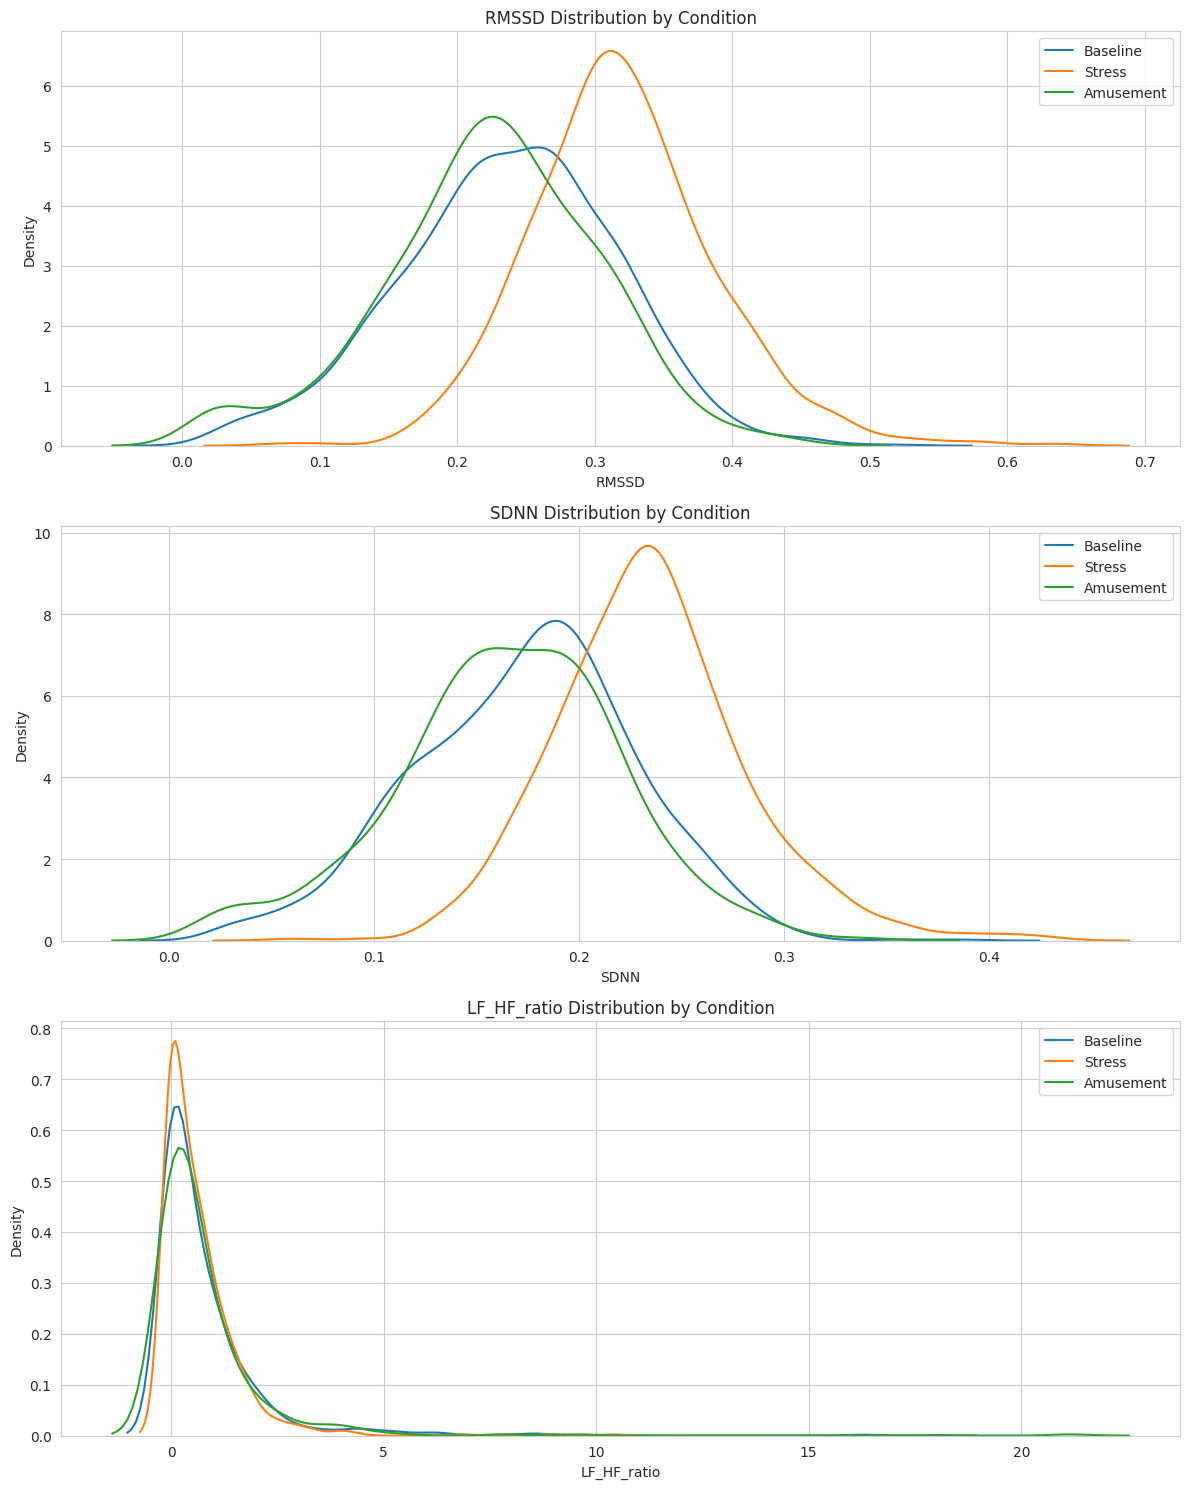

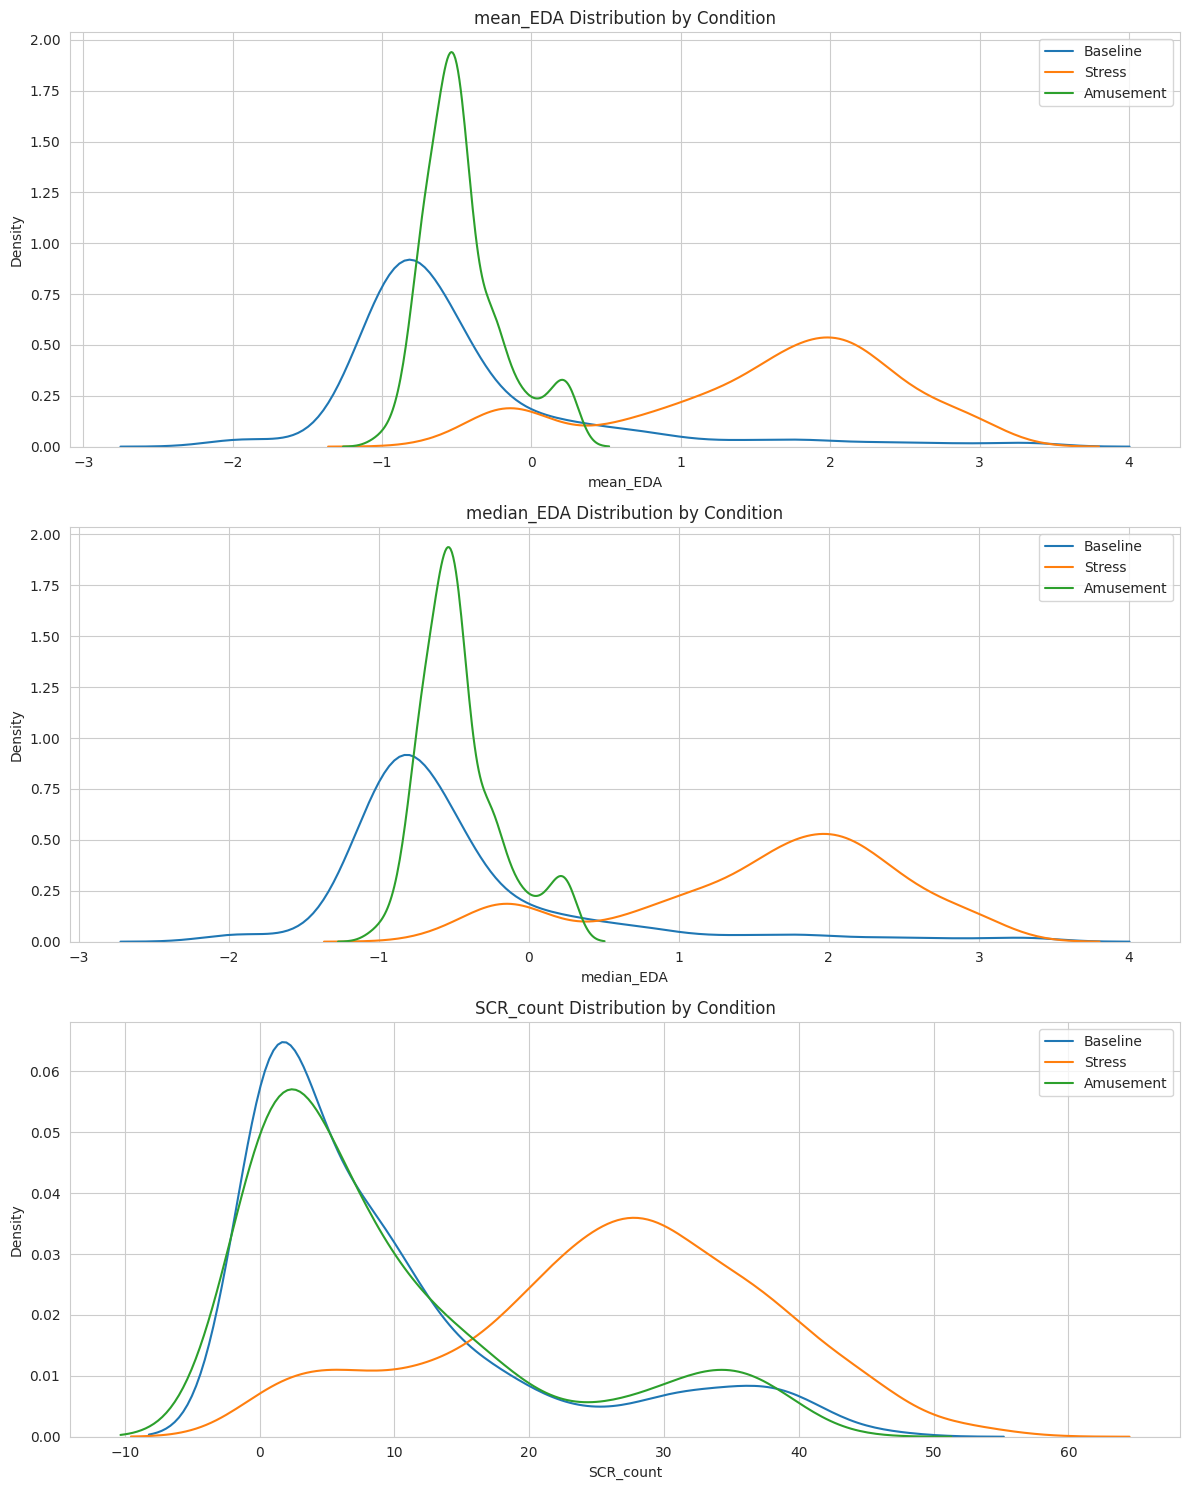

In [4]:
def plot_feature_distributions(df, features, conditions):
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 5*n_features))
    
    for idx, feature in enumerate(features):
        ax = axes[idx] if n_features > 1 else axes
        for condition in conditions:
            sns.kdeplot(data=df[df['condition'] == condition][feature],
                       label=condition, ax=ax)
        ax.set_title(f'{feature} Distribution by Condition')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Plot HRV metrics distributions
hrv_features = ['RMSSD', 'SDNN', 'LF_HF_ratio']
conditions = ['Baseline', 'Stress', 'Amusement']
plot_feature_distributions(features_df, hrv_features, conditions)

# Plot EDA features distributions
eda_features = ['mean_EDA', 'median_EDA', 'SCR_count']
plot_feature_distributions(features_df, eda_features, conditions)

## 3. Statistical Analysis

In [5]:
def perform_anova(df, feature):
    groups = [group for _, group in df.groupby('condition')[feature]]
    f_stat, p_val = stats.f_oneway(*groups)
    return f_stat, p_val

# Perform one-way ANOVA for each feature
features = hrv_features + eda_features
anova_results = []

for feature in features:
    f_stat, p_val = perform_anova(features_df, feature)
    anova_results.append({
        'Feature': feature,
        'F-statistic': f_stat,
        'p-value': p_val
    })

anova_df = pd.DataFrame(anova_results)
print("One-way ANOVA Results:")
print(anova_df)

One-way ANOVA Results:
       Feature  F-statistic  p-value
0        RMSSD      324.735    0.000
1         SDNN      363.967    0.000
2  LF_HF_ratio        2.989    0.051
3     mean_EDA     1578.528    0.000
4   median_EDA     1561.949    0.000
5    SCR_count      491.756    0.000


## 4. Correlation Analysis

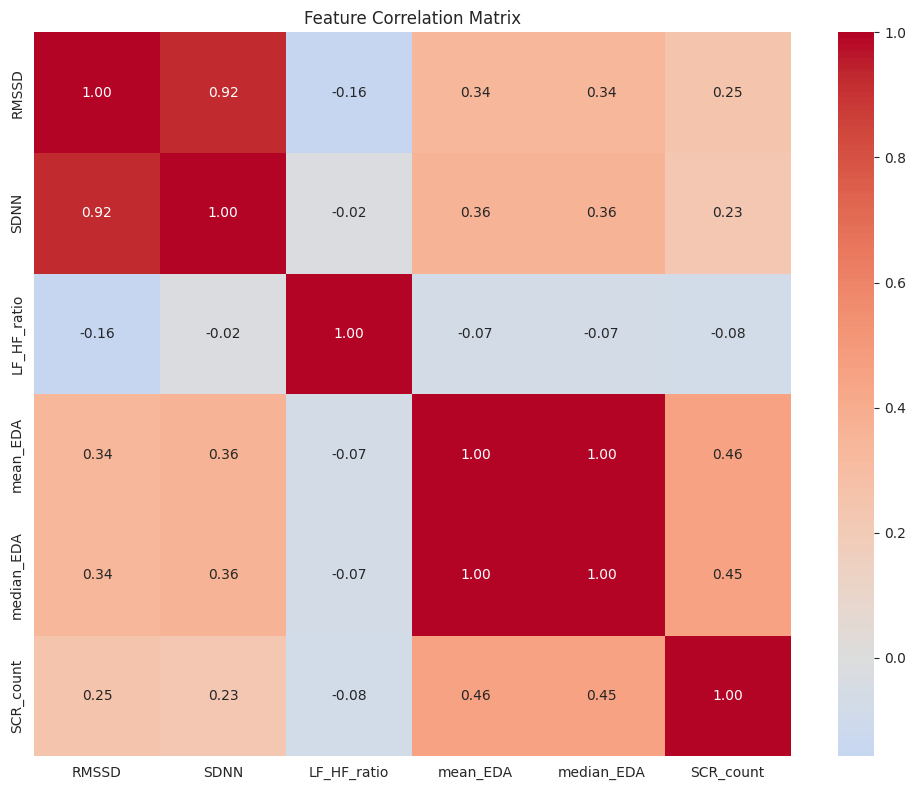

In [6]:
# Calculate correlation matrix
correlation_features = features_df[features].copy()
correlation_matrix = correlation_features.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Time Series Analysis

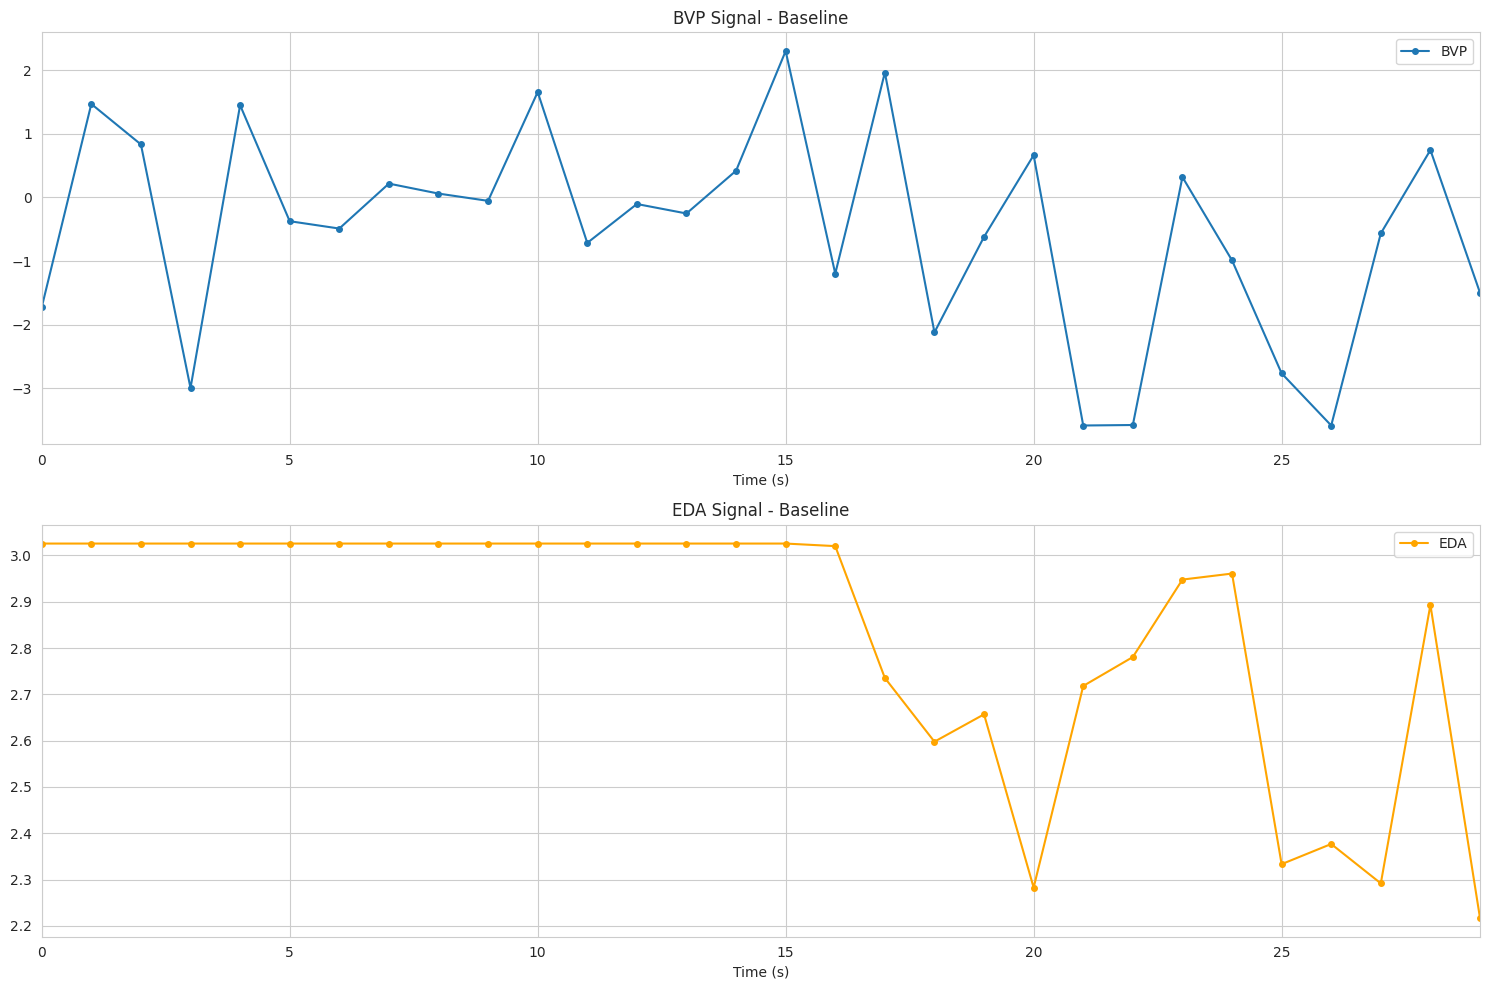

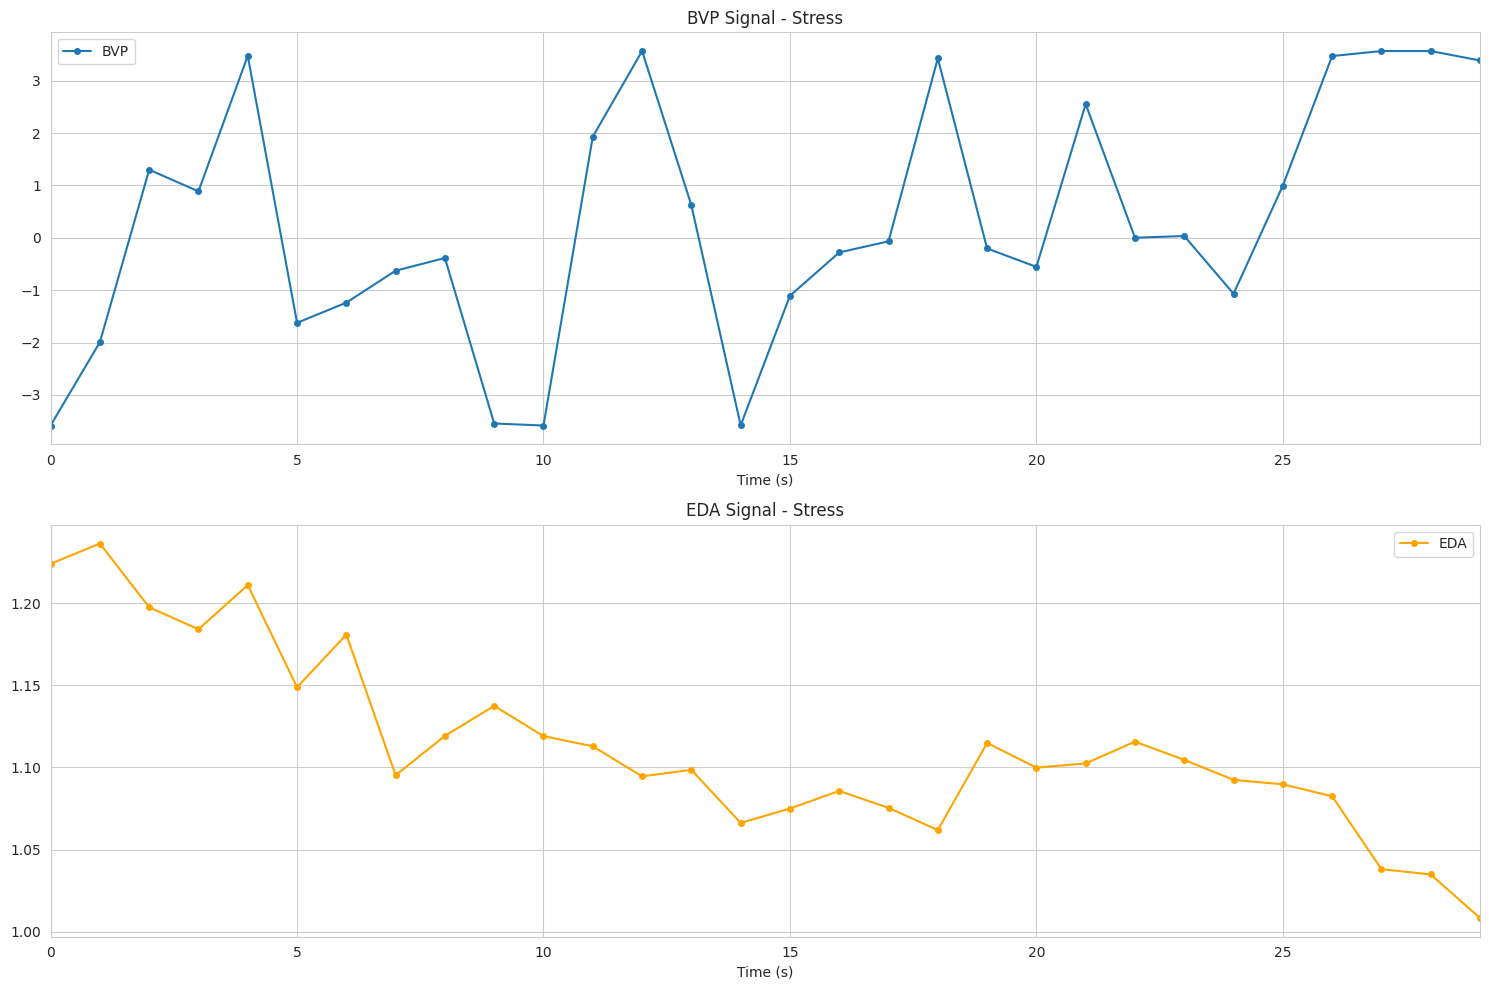

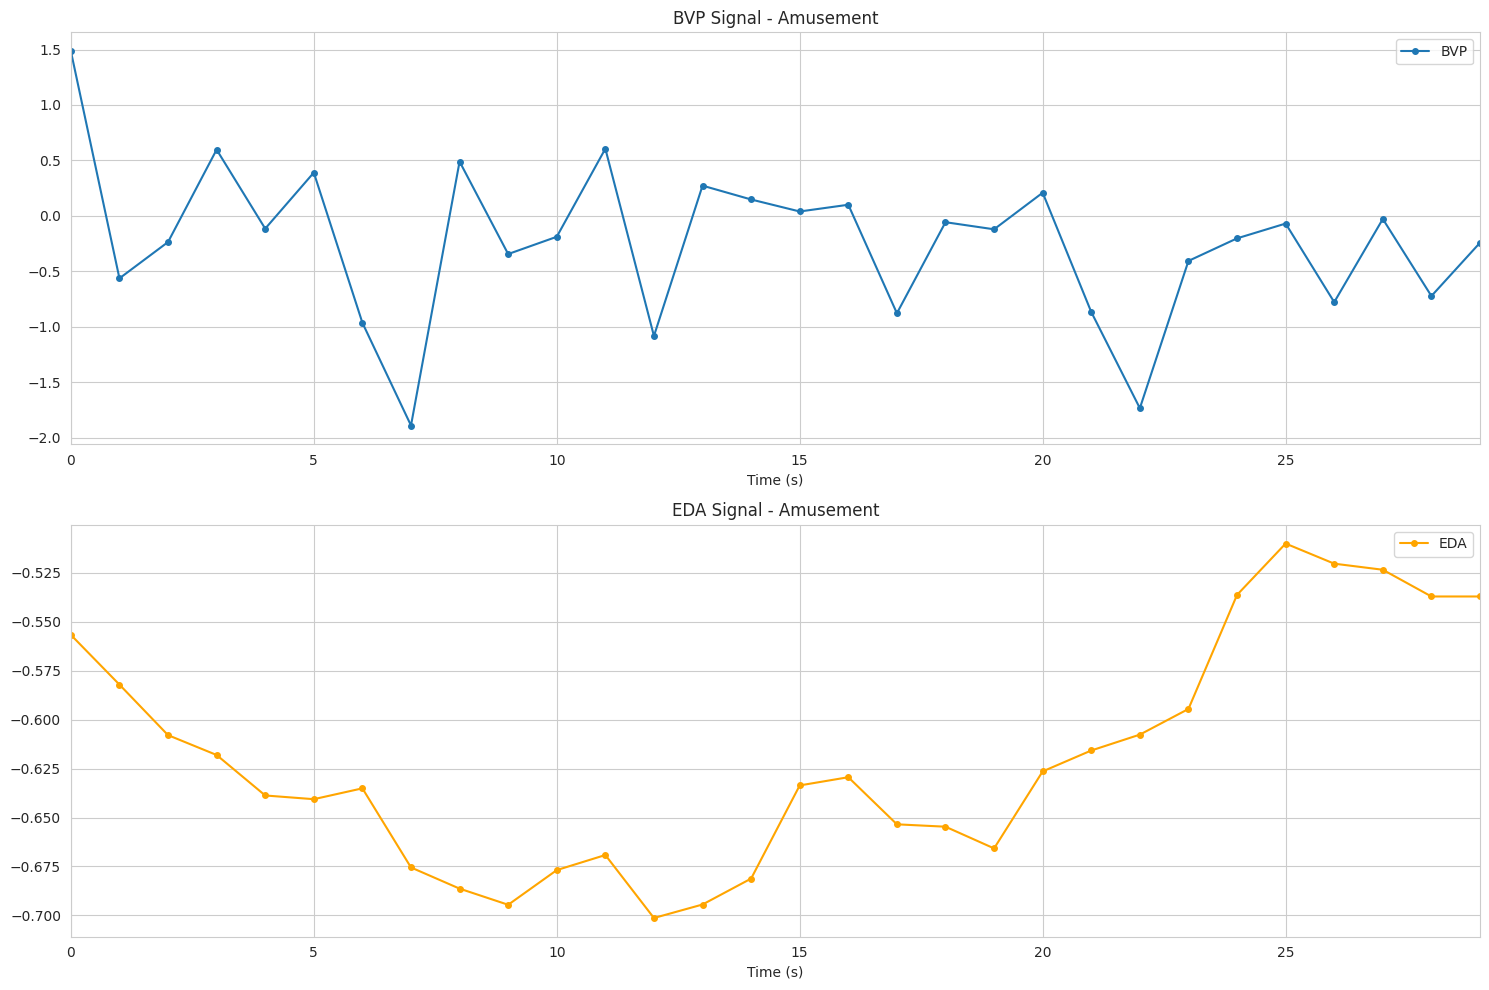

In [7]:
def plot_sample_signals(data, label, sample_idx=0):
    """
    Plots the BVP and EDA signals for the specified label and sample index.
    
    Note: Signals have been downsampled to exactly 30 time steps (1 point per second).
    """
    # Convert the selected sample to NumPy arrays and flatten (time dimension).
    # data['BVP_series'][label] has shape [num_samples_for_label, 30, 1].
    bvp_signal = data['BVP_series'][label][sample_idx].numpy().flatten()
    eda_signal = data['EDA_series'][label][sample_idx].numpy().flatten()
    
    # Get a descriptive label name (e.g., "Baseline", "Stress", or "Amusement").
    condition_name = label_map.get(label, f"Label {label}")

    # Create time axes - since we've downsampled to exactly 30 points for 30 seconds
    # Each point represents exactly 1 second
    time_axis = np.linspace(0, 29, 30)  # 0 to 29 inclusive (30 points)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot BVP signal
    ax1.plot(time_axis, bvp_signal, label='BVP', marker='o', linestyle='-', markersize=4)
    ax1.set_title(f'BVP Signal - {condition_name}')
    ax1.set_xlabel('Time (s)')
    ax1.set_xlim(0, 29)
    ax1.legend()
    
    # Plot EDA signal
    ax2.plot(time_axis, eda_signal, label='EDA', color='orange', marker='o', linestyle='-', markersize=4)
    ax2.set_title(f'EDA Signal - {condition_name}')
    ax2.set_xlabel('Time (s)')
    ax2.set_xlim(0, 29)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage: plot the first sample (sample_idx=0) for each condition
for cond_label in [1, 2, 3]:  # Using integer labels instead of floats for simplicity
    plot_sample_signals(data, label=cond_label, sample_idx=0)

## 6. Class Distribution Analysis

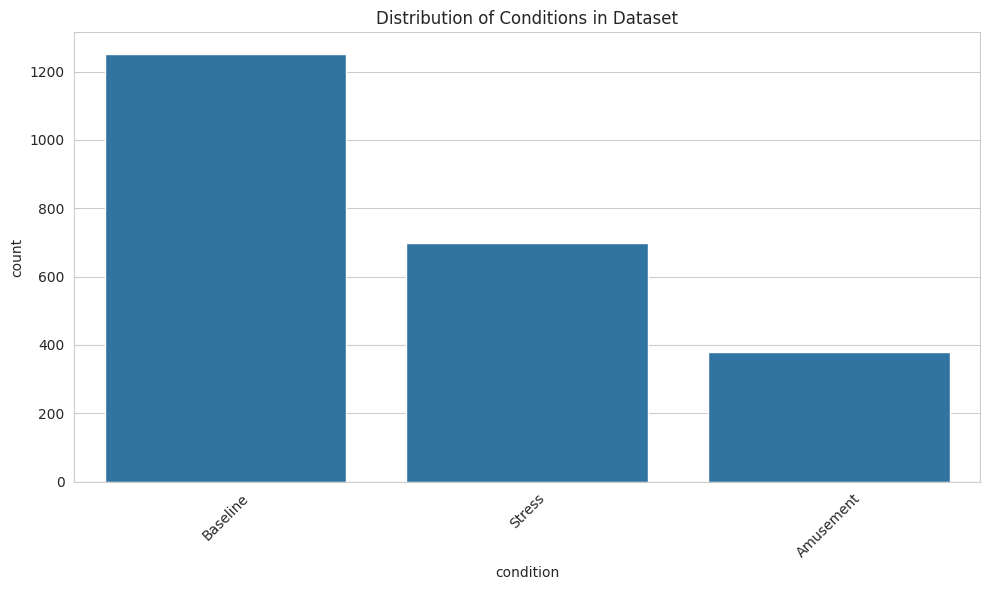


Class Distribution (%):

condition
Baseline    53.757
Stress      30.013
Amusement   16.230
Name: proportion, dtype: float64


In [8]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=features_df, x='condition')
plt.title('Distribution of Conditions in Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print class distribution percentages
class_dist = features_df['condition'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):\n")
print(class_dist)

## 7. Feature Importance Analysis

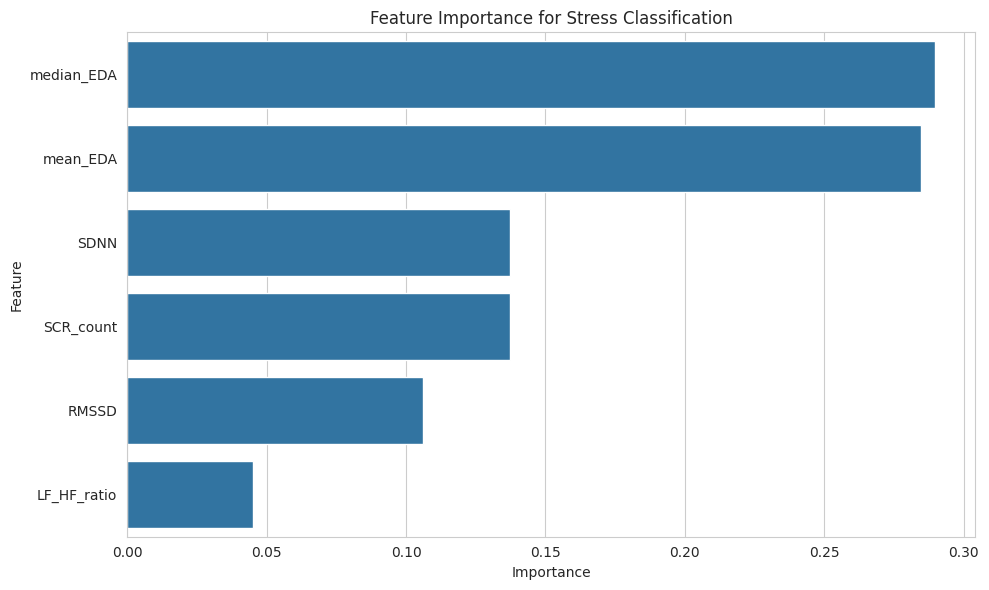

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Prepare data for feature importance analysis
X = features_df[features].copy()
y = features_df['label']

# Handle missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Plot feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance for Stress Classification')
plt.tight_layout()
plt.show()

## 8. Summary and Insights

Key findings from the exploratory data analysis:

1. **Data Distribution**:
   - Analyzed the distribution of HRV metrics (RMSSD, SDNN, LF/HF ratio)
   - Examined EDA features (mean, median, SCR count)
   - Identified potential differences across conditions

2. **Statistical Analysis**:
   - Performed one-way ANOVA to test for significant differences between conditions
   - Identified which features show significant variation across stress states

3. **Feature Correlations**:
   - Examined relationships between different physiological measures
   - Identified potential redundant features

4. **Time Series Patterns**:
   - Visualized raw BVP and EDA signals
   - Observed characteristic patterns for different conditions

5. **Class Distribution**:
   - Analyzed the balance of different conditions in the dataset
   - Important consideration for model development

6. **Feature Importance**:
   - Identified most discriminative features for stress detection
   - Provides guidance for feature selection in modeling